In [1]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt
import shutil
import glob
#SKlearn SVM
from sklearn import svm
from sklearn.decomposition import PCA
import math

In [2]:
#Base Folder Paths
base_folder_name = 'converted'
test_folder_name = 'test2'
base_path = os.path.join(base_folder_name, test_folder_name)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    #Test and Train data Folders
    sample_train_path = os.path.join(base_path, sample_dir_name+'_train')
    os.makedirs(sample_train_path, exist_ok=True)
    sample_test_path = os.path.join(base_path, sample_dir_name+'_test')
    os.makedirs(sample_test_path, exist_ok=True)
    #Clustering folders
    cluster_train_path = os.path.join(sample_train_path, 'cluster')
    os.makedirs(cluster_train_path, exist_ok=True)
    cluster_test_path = os.path.join(sample_test_path, 'cluster')
    os.makedirs(cluster_test_path, exist_ok=True)
#Defining features
features = [1, 6, 17] #(ICMP:1, TCP:6, UDP:17)    

In [3]:
def filter_ip(df, ip_addr):
    with open(os.path.join(base_path,"filtered_ip_feture_vector"), "a+") as f:
        df.loc[ip_addr].to_csv(f, header=False)
    df = df.drop([ip_addr])
    return df    

In [4]:
def get_feature_dataframe(sample_file, features):
        df = pd.read_csv(sample_file, index_col=0)
        #Filter Columns
        df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
        #Remove null destinations
        df = df[df['ip.dst'].notnull()]
        #Rename Columns
        df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
        #Get count for each ip
        df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
        #Drop row for given IP
        #df = filter_ip(df, '147.32.84.165')        
        if(set(df.columns) != set(features)):
            non_columns = set(features) - set(df.columns)
            for c in non_columns:
                df.insert(loc=features.index(c), column=c, value=0)
        #Select only required protocols which would be used as features
        df = df[features]
        return df

In [5]:
filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
df = get_feature_dataframe(filenames[0], features)

In [6]:
df.head()

protocol,1,6,17
ip,,,
104.107.0.221,0,21,0
104.107.1.225,0,340,0
104.107.30.247,0,59,0
104.107.6.192,0,321,0
104.107.6.212,0,55,0


In [7]:
#Merge sample files to create bigger sameple
def merge_files(files, merge_count, features):
    if len(files) < merge_count:
        print('Too few file to merge')
        return
    dfs = []
    count = 0
    for file in files:
        if count == 0:
            df = get_feature_dataframe(file, features)
            count += 1
        else:
            temp_df = get_feature_dataframe(file, features)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df = df.groupby(df.index).sum()
            dfs.append(df)
            count = 0
    return dfs

In [8]:
def create_train_test(sample_path, features):
    train_dfs = []; test_dfs = []
    filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
    file_count = len(filenames)
    #Split train and test Train size 80% of data and 20% (1/5 th) is test
    reminder = file_count%5
    #Number of files to be combined to form one train/test data
    merge_count = 1 #int((file_count - reminder) / 5)
    
#     train_files = filenames[:merge_count*4]
#     test_files = filenames[merge_count*4:]

    train_files = filenames[:file_count-1]
    test_files = filenames[file_count-1:]
    
    train_dfs = merge_files(train_files, merge_count, features)
    test_dfs = merge_files(test_files, merge_count, features)
    return train_dfs, test_dfs, merge_count

In [9]:
train_dfs, test_dfs, merge_count = create_train_test(sample_path, features)

In [10]:
np.savetxt(os.path.join(base_path, 'merge_count'), np.asarray(merge_count).reshape(1,), fmt='%d')

In [11]:
#Write train and test data to file
train_files = []
for i, df in enumerate(train_dfs, 1):
    train_file = os.path.join(sample_train_path,str(i))
    df.to_csv(train_file)
    train_files.append(train_file)
test_files = []    
for i, df in enumerate(test_dfs, 1):
    test_file = os.path.join(sample_test_path,str(i))
    df.to_csv(test_file)
    test_files.append(test_file)

In [12]:
from sklearn.cluster import KMeans
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans):
    elbow_count = 0
    range_val = 10
    nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            opt_clust_count = i
            break
#     plt.plot(nc,score)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Score')
#     plt.title('Elbow Curve')
#     plt.show()
    return opt_clust_count

In [13]:
#Apply elbow method on all the samples and get their mean
def get_optimal_cluster_count(df_list):
    elbow_vals = []
    for df in df_list:
        X = df.values
        #Create scaling
        scaler = preprocessing.StandardScaler().fit(X)
        #Transform Traning data
        X_trans = scaler.transform(X)
        elbow = elbow_method(X_trans)
        elbow_vals.append(elbow)
    return int(np.floor(np.mean(elbow_vals)))

In [14]:
cluster_count = get_optimal_cluster_count(train_dfs)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
cluster_count

4

In [16]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [17]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ 
    X: feature vector 
    cluster_count: Number of clusters to be used for k-means
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [18]:
#Find the median of all the centroid which will be better estimate of the centroid for all future k-means clustering
def kmeans_common_create_centroids(sample_frames, features, cluster_count, centroid_filename, features_filename):
    """
    sample_frames: list of feature vector datafames
    centroid_filename: File in which centroid has to be stored for future analyasis
    features_filename: File in which feature list will be stored
    """
    df_concat = pd.DataFrame(columns=features)
    for df in sample_frames:
        #Run kmeans and get centroid
        df_centroid = get_kmeans_centroid(df, cluster_count)
        #Create list of centroids
        df_concat = df_concat.append(df_centroid)
    centroids = []
    #Find median for each centroid and store them in file
    for c in range(cluster_count):
        med = np.median(df_concat.loc[c], axis=0) # e.g. df_concat.loc[0] is df of clister 0
        centroids.append(med)
    #Save centroids and features in files for future use
    np.savetxt(os.path.join(base_path, centroid_filename), np.asarray(centroids), delimiter=",")
    np.savetxt(os.path.join(base_path, features_filename), np.asarray(list(features)), delimiter=",")
    return centroids, features

In [19]:
#File to store centroids
centroid_filename = 'centroids.csv'
#File to store feature list
features_filename = 'features.csv'
#Call to find median of centroid
kmeans_common_create_centroids(train_dfs, features, cluster_count, centroid_filename, features_filename)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


([array([-0.16815612, -0.14928111, -0.16948046]),
  array([-0.18181818,  5.13527652,  5.68956244]),
  array([ 5.08663322, -0.27110845, -0.099885  ]),
  array([-0.18670401, -0.18804342, -0.018538  ])],
 [1, 6, 17])

In [20]:
#Get centroids and feature from the files
def read_centroid_features(centroid_filename, features_filename):
    centroids = np.genfromtxt(os.path.join(base_path,centroid_filename), delimiter=',')
    features = np.genfromtxt(os.path.join(base_path,features_filename), delimiter=',')
    features = list(features.astype('int64'))
    return centroids, features        

In [21]:
def draw_clusters(X, pre_centroids, ax, title):
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
        km = KMeans(n_clusters=pre_centroids.shape[0])
        km.fit(reduced_X)
    else:
        reduced_X = X
        km = KMeans(n_clusters=pre_centroids.shape[0], init=pre_centroids)
        km.fit(reduced_X)
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    centroids = km.cluster_centers_
    ax.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3)
    # Plot the centroids as a white X
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [22]:
centroids, features = read_centroid_features(centroid_filename, features_filename)

## Plot k-means clustering for samples

### Print only 4 clustering plots

In [23]:
to_print_df = train_dfs[:4]

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


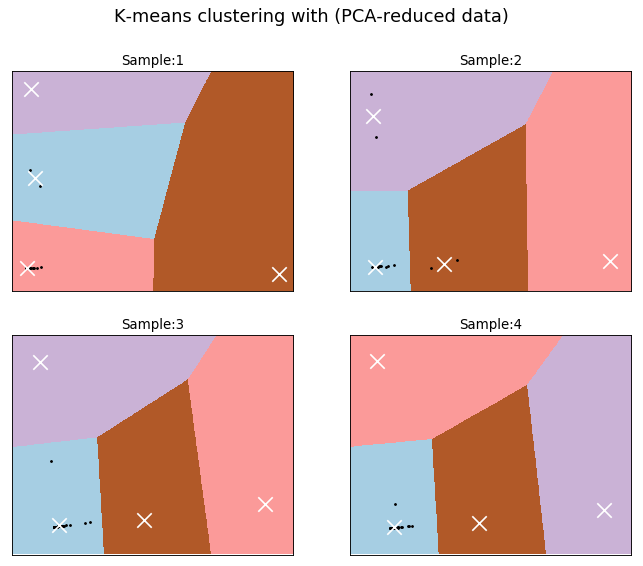

In [24]:
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
row_count = math.ceil(len(to_print_df)/2)
for i, df in enumerate(to_print_df, 1):
    X = df.values
    #Create scaling
    X_trans = preprocessing.StandardScaler().fit_transform(X)
    #Use PCA component analysis for visuals
    ax = fig.add_subplot(2, 2, i)
    plt.suptitle('K-means clustering with (PCA-reduced data)', fontsize=16)
    title = 'Sample:'+str(i)
    draw_clusters(X_trans, centroids, ax, title)
plt.savefig('kemans-clusterng.png')    

## Do k-means clustering and save clustered output in the files

In [25]:
def kmeans_clustering(feature_df, centroids):
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #k means clustering using provided centroids 
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Getting the labels/clusters and distances of each IP from centroid
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching label and distance to existing df and write new dataframe to file
    df = pd.concat([feature_df.reset_index(), cluster_df], axis=1).set_index('ip')
    return df

In [26]:
#Cluster all the samples and store them
centroids, features = read_centroid_features(centroid_filename, features_filename)
for i, train_df in enumerate(train_dfs):
    clustered_df = kmeans_clustering(train_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_train_path,str(i+1)))
for i, test_df in enumerate(test_dfs): 
    clustered_df = kmeans_clustering(test_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_test_path,str(i+1)))    

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [27]:
print(centroids)

[[-0.16815612 -0.14928111 -0.16948046]
 [-0.18181818  5.13527652  5.68956244]
 [ 5.08663322 -0.27110845 -0.099885  ]
 [-0.18670401 -0.18804342 -0.018538  ]]


In [28]:
def ge_clustering_results(cluster_path):
    files = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for file in files:
        if first:
            df = pd.read_csv(file, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(file, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['ip'])
    
    #Merge the duplicates
    new_columns =  ['cluster', 'packet_count']
    features = list(df.columns[:-1])
    cluster_column = list(df.columns[-1:])
    #Average packet count across all the samples
    packet_count = df[features].groupby('ip').mean().sum(axis=1).astype('int64')
    #most occuring cluster across all samples
    cluster = df[cluster_column].groupby('ip').median().astype('int64')
    #Create new dataframe with cluster and packet count 
    new_df = pd.concat([cluster, packet_count], axis=1)
    new_df.columns = new_columns
    return new_df

In [29]:
train_df = ge_clustering_results(cluster_train_path)
test_df = ge_clustering_results(cluster_test_path)

In [30]:
train_df.shape, test_df.shape

((267, 2), (34, 2))

In [31]:
#Save train result to file
train_tag_filename = 'ip_cluster_tag_train'
tag_file = os.path.join(base_path,train_tag_filename)
train_df.to_csv(tag_file)
#Save test result to file
test_tag_filename = 'ip_cluster_tag_test'
tag_file = os.path.join(base_path,test_tag_filename)
test_df.to_csv(tag_file)

In [32]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = pd.read_csv(train_tag_file, index_col=0)
test_tag_filename = 'ip_cluster_tag_test'
test_tag_file = os.path.join(base_path,test_tag_filename)
test_df = pd.read_csv(test_tag_file, index_col=0)

In [33]:
import numpy as np
from scipy.misc import comb

def get_rand_index_score(train_df, test_df):
    r = pd.merge(train_df, test_df, left_index=True, right_index=True, how='right')
    r = r.dropna()
    r = r.astype(int)
    actual_clusters = r.iloc[:,0].tolist()
    predicted_clusters = r.iloc[:,1].tolist()    
    
    tp_plus_fp = comb(np.bincount(actual_clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(predicted_clusters), 2).sum()
    A = np.c_[(actual_clusters, predicted_clusters)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual_clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    ri =  (tp + tn) / (tp + fp + fn + tn)
    return ri

In [34]:
get_rand_index_score(train_df, test_df)

0.45276292335115864

## Anamoly Detection Using One Class SVM

In [35]:
#Create feature vector corrosponding to each cluster. 
#This feature vector would be used to define boundray using One Class SVM for the cluster.
def get_clusters_feature_vectors(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
            #print(df)
            break
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].values
    return cluster_dict

In [36]:
def plot_outlier_detecton(X, classifier, title):
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
        clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
        clf.fit(reduced_X)
    else:
        reduced_X = X
        clf = classifier
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("Outlier Detection:" + str(title))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    #plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    s = 40
    b1 = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c='white', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")
    plt.show()

In [61]:
def plot_outlier_detecton1(X, ax, title):
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
    else:
        reduced_X = X
    
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(reduced_X)
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_title(title)
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

    s = 40
    b1 = ax.scatter(reduced_X[:, 0], reduced_X[:, 1], c='white', s=s, edgecolors='k')
    #ax.set_axis('tight')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")

In [38]:
cluster_feature_dict = get_clusters_feature_vectors(cluster_train_path)

In [39]:
#cluster_feature_dict[0]

2


/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


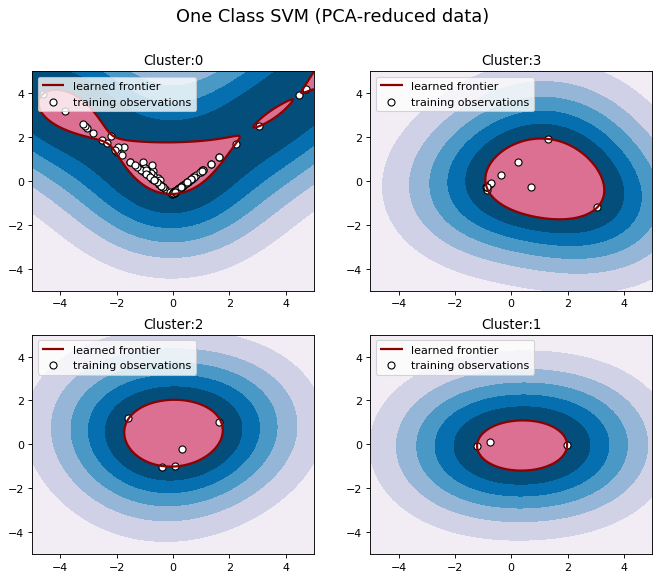

In [63]:
import math
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
row_count = math.ceil(len(cluster_feature_dict)/2)
print(row_count)
for i, (cluster, X) in enumerate(cluster_feature_dict.items(), 1):
    #Create scaling
    X_trans = preprocessing.StandardScaler().fit_transform(X)
    ax = fig.add_subplot(row_count, 2, i)
    plt.suptitle('One Class SVM (PCA-reduced data)', fontsize=16)
    title = 'Cluster:'+str(cluster)
    if (X_trans.shape[0] >= X_trans.shape[1]):
        plot_outlier_detecton1(X_trans, ax, title)
plt.savefig('oneclassSVM.png')

In [41]:
def one_class_svm(feature_vector, cluster):
    X_train = feature_vector
    #Get scaler
    scaler = preprocessing.StandardScaler().fit(X_train)
    #Transform Traning data
    X_trans = scaler.transform(X_train)
    # fit the model
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(X_trans)
    clf.name = 'svm'
    #Plot the graph
    title = ' Cluster '+ str(cluster)
    plot_outlier_detecton(X_trans, clf, title)
    return clf, scaler

In [42]:
cluster_train_path

'converted/test2/samp_train/cluster'

In [43]:
#cluster_feature_dict[3]

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


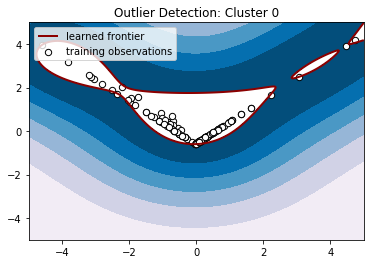

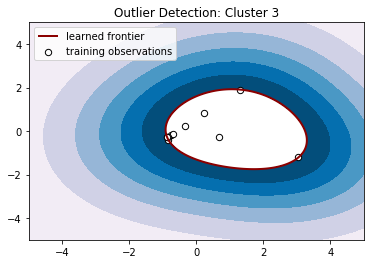

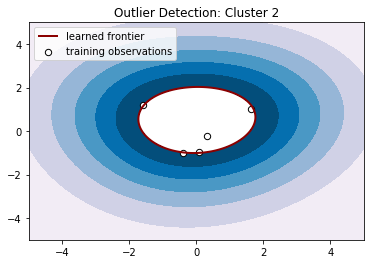

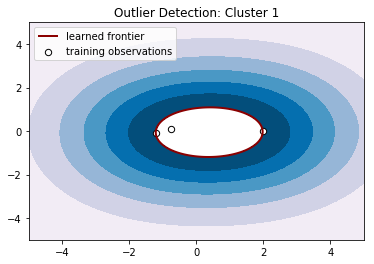

In [44]:
clf_dict = dict()
scaler_dict = dict()
for cluster, df in cluster_feature_dict.items():
    clf_dict[cluster], scaler_dict[cluster] = one_class_svm(df, cluster)

In [45]:
#Predict for the give destination if it is normal or not
X_test = [[0,658,0]]#[[1491,18]]
X_test_tran = scaler_dict[0].transform(X_test)
clf_dict[0].predict(X_test_tran)

array([-1])

In [46]:
#plot_outlier_detecton(X_test_tran, clf_dict[0], 'test')

## Clustering the data captures during attack

In [47]:
attack_sample_dir_name = 'attack_samp'
attack_sample_path = os.path.join(base_path, attack_sample_dir_name)
attack_sample_train_path = os.path.join(base_path, attack_sample_dir_name+'_train')
os.makedirs(attack_sample_train_path, exist_ok=True)
attack_cluster_path = os.path.join(attack_sample_train_path, 'cluster')
os.makedirs(attack_cluster_path, exist_ok=True)

In [48]:
files = sorted(glob.glob(os.path.join(attack_sample_path,'*')),  key=os.path.getmtime)
merge_count = np.genfromtxt(os.path.join(base_path,'merge_count'))

In [49]:
files

[]

In [50]:
int(merge_count)

1

In [51]:
centroids, features = read_centroid_features(centroid_filename, features_filename)

In [52]:
attack_dfs = merge_files(files, merge_count, features)

Too few file to merge


In [53]:
#Cluster all the samples and store them
centroids, features = read_centroid_features(centroid_filename, features_filename)
for i, attack_df in enumerate(attack_dfs):
    clustered_df = kmeans_clustering(attack_df, centroids)
    clustered_df.to_csv(os.path.join(attack_cluster_path,str(i+1)))

TypeError: 'NoneType' object is not iterable

In [ ]:
files = sorted(glob.glob(os.path.join(attack_cluster_path,'*')),  key=os.path.getmtime)
df = pd.read_csv(files[0], index_col=0)

In [ ]:
df.shape

In [ ]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = pd.read_csv(train_tag_file, index_col=0)

In [ ]:
train_df.head()

In [ ]:
train_df.loc['192.168.0.7']

In [ ]:
bad_ip_df = pd.DataFrame(columns=['ip', 'packet_count', 'cluster'])
for ip, row in df.iterrows():
    feature_row = row[:-1]
    cluster_value = row[-1]
    #cluster test
    if ip in train_df.index:
        packet_count = feature_row.sum()
        train_cluster = train_df.loc[ip]['cluster']
        #Compare each ip data with the train cluster 
        if(cluster_value == train_cluster):
            #SVM test: Check if its inside the boundry usinf one class svm
            X_test_tran = scaler_dict[cluster_value].transform([feature_row.values])
            prediction = clf_dict[cluster_value].predict(X_test_tran)
            if prediction == - 1:
                s = pd.Series([ip, packet_count, cluster_value], index=bad_ip_df.columns)
                bad_ip_df = bad_ip_df.append(s, ignore_index=True)
        else:
            s = pd.Series([ip, packet_count, cluster_value], index=bad_ip_df.columns)
            bad_ip_df = bad_ip_df.append(s, ignore_index=True)
            
bad_ip_df = bad_ip_df.set_index('ip')
print(bad_ip_df)